# SMILES-BERT embeddings

This notebook loads DrugBank SMILES, encodes each molecule with a SMILES-BERT model, appends the 768-dim embeddings to the dataframe, saves a CSV, and visualizes structure with t-SNE and UMAP. The goal is a clean, reproducible path from raw SMILES to interpretable plots.


## Setup

- Install missing packages if Colab doesn’t already have them.
- Mount Google Drive for input/output.



In [1]:
#One time install
!pip install transformers


In [2]:
#Install if any of them are missing
!pip install pandas numpy torch


In [3]:
!pip install umap-learn


In [4]:
# Core data + numerics + tensors
import pandas as pd
import numpy as np
import torch

# Visualisation
import matplotlib.pyplot as plt

# Dimensionality reduction
from sklearn.manifold import TSNE
import umap

# Model + utilities
from transformers import BertTokenizer, BertModel
from tqdm import tqdm

#To download the file
from google.colab import files

# Dimensionality reduction / preprocessing
from sklearn.decomposition import PCA, TruncatedSVD # linear pre-reduction (dense/sparse)
from sklearn.manifold import TSNE                   # t-SNE 2D mapping
from sklearn.preprocessing import StandardScaler    # feature scaling for PCA
import umap                                         # UMAP 2D mapping


In [5]:
# Mount Drive so we can read the SMILES CSV and save outputs back
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


## Data load

- Input: `drugbank_smiles_final.csv`
- Expected columns: `DrugBankID`, `Name`, `SMILES`, `ATC_Codes`, `Label`
- `Label` is precomputed upstream from ATC codes (binary: cancer vs non-cancer). This notebook **only** consumes those labels; it doesn’t relabel anything.
- Quick sanity checks after load: shape, head, and a peek at `SMILES`/`Label`.


In [6]:
# Path to input CSV
smiles_path= '/content/drive/My Drive/drugbank_smiles_final.csv'

print("Loaded from Google Drive!")

Loaded from Google Drive!


In [7]:
# Read the DrugBank dataframe (expects columns like: DrugBankID, Name, SMILES, ATC_Codes, Label)
df = pd.read_csv(smiles_path)
print("Data loaded with shape:", df.shape)
print(df.head())

Data loaded with shape: (12306, 5)
  DrugBankID          Name                                             SMILES  \
0    DB00006   Bivalirudin  CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...   
1    DB00014     Goserelin  CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...   
2    DB00027  Gramicidin D  CC(C)C[C@@H](NC(=O)CNC(=O)[C@@H](NC=O)C(C)C)C(...   
3    DB00035  Desmopressin  NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...   
4    DB00050    Cetrorelix  CC(C)C[C@H](NC(=O)[C@@H](CCCNC(N)=O)NC(=O)[C@H...   

     ATC_Codes  Label  
0  ['B01AE06']      0  
1  ['L02AE03']      0  
2  ['R02AB30']      0  
3  ['H01BA02']      0  
4  ['H01CC02']      0  


## SMILES-BERT model

- Checkpoint: `unikei/bert-base-smiles`
- We use the **pooled [CLS] output** (768-dim) as the fixed-length molecular representation.
- Inference only: model in `eval()` and no gradients.
- Device: GPU if available, otherwise CPU.


In [8]:
# Load tokenizer and model for SMILES-BERT
tokenizer = BertTokenizer.from_pretrained("unikei/bert-base-smiles")
model = BertModel.from_pretrained("unikei/bert-base-smiles")


# Encoding only; set eval mode (disables dropout)
model.eval()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/315 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [9]:
# Use GPU if Colab has one; otherwise fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Printing the module summary is handy for sanity checks
model


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

## Embedding function (single SMILES → 768-vector)

- Tokenize the SMILES string and move tensors to device.
- Forward pass once; collect `pooler_output`.
- On tokenization errors, return a zero vector so row counts stay aligned. Errors are printed for later inspection.


In [10]:
# Encode a single SMILES string and return the [CLS] pooled embedding (768-dim)
def get_cls_embedding(smiles_str):
    try:
        # Tokenize and move tensors to the chosen device
        inputs = tokenizer(smiles_str, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Inference only (no gradients needed)
        with torch.no_grad():
            outputs = model(**inputs)

        # Take the pooled output ([CLS]) as the representation
        return outputs.pooler_output.squeeze().cpu().numpy()  # [CLS] token
    except Exception as e:
        # If a molecule fails to tokenize/encode, keep row count aligned with a
        # zero vector
        print(f"❌ Failed for: {smiles_str}")
        return np.zeros(768)  # fallback embedding


## Encode the dataset

- Iterate through `df['SMILES']` and collect each 768-vector.
- This loop is simple and readable. If runtime matters, replace with batched encoding later.
- After encoding, stack to `(n_samples, 768)`.


In [11]:
# Encode each SMILES into a 768-dim vector
embeddings = []
for smi in tqdm(df['SMILES'], desc="Encoding SMILES"):
    emb = get_cls_embedding(smi)
    embeddings.append(emb)


Encoding SMILES: 100%|██████████| 12306/12306 [48:37<00:00,  4.22it/s]


## Attach embeddings and save

- Add columns `emb_0 … emb_767` to the dataframe.
- Save `drug_embeddings_final.csv` back to Drive and (optionally) also as a local download.
- Sanity checks: head, a couple of columns, and the last few embedding column names.


In [12]:
# Stack the list into a (n_samples, 768) array
embedding_array = np.vstack(embeddings)  # shape: (n_samples, 768)

# Add as new columns to df
for i in range(embedding_array.shape[1]):
    df[f'emb_{i}'] = embedding_array[:, i]

print("Embeddings added to DataFrame!")


/tmp/ipython-input-4247743328.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'emb_{i}'] = embedding_array[:, i]
/tmp/ipython-input-4247743328.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'emb_{i}'] = embedding_array[:, i]
/tmp/ipython-input-4247743328.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newf

Embeddings added to DataFrame!


/tmp/ipython-input-4247743328.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'emb_{i}'] = embedding_array[:, i]
/tmp/ipython-input-4247743328.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'emb_{i}'] = embedding_array[:, i]
/tmp/ipython-input-4247743328.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newf

In [13]:
# Files saved to Google Drive
df.to_csv('/content/drive/My Drive/drug_embeddings_final.csv', index=False)

print("Files saved to Google Drive")


Files saved to Google Drive


In [14]:
# Spot checks (shape, sample rows, last few columns)
df.head()  # shows the first 5 rows

# To show more rows:
df.head(10)  # first 10 rows

# To see just SMILES and label:
df[['SMILES', 'Label']].head()

# To check if embedding columns are added:
print(df.columns[-5:])  # shows last 5 columns (should be emb_763, emb_764...)


Index(['emb_763', 'emb_764', 'emb_765', 'emb_766', 'emb_767'], dtype='object')


In [15]:
from google.colab import files

# Save CSV and download it
df.to_csv('drug_embeddings_final.csv', index=False)
files.download('drug_embeddings_final.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### t-SNE on embeddings

- **Input:** SMILES-BERT embeddings `(n × 768)`.  
- **Pre-reduction:** `StandardScaler → PCA(50)` to improve stability and speed.  
- **t-SNE settings:** `perplexity=30`, `learning_rate=200`, `n_iter=1000`, `init="pca"`, `metric="cosine"`, `random_state=42`.  
- **Rationale:** PCA reduces noise and runtime; cosine suits embeddings; t-SNE emphasizes local neighborhoods (global distances are not to scale).


In [16]:
# Helper to plot 2D embeddings
def plot_2d(emb2d, labels, title="2D projection", s=10):
    emb2d = np.asarray(emb2d)
    labels = np.asarray(labels)
    fig, ax = plt.subplots(figsize=(6.5, 5.5), dpi=130)
    classes = pd.Series(labels).astype(str).values
    uniq = pd.unique(classes)
    for c in uniq:
        m = classes == c
        ax.scatter(emb2d[m, 0], emb2d[m, 1], s=s, alpha=0.8, label=str(c))
    ax.set_title(title)
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")
    ax.legend(markerscale=1.5, bbox_to_anchor=(1.04, 1), loc="upper left", borderaxespad=0.)
    plt.tight_layout()
    plt.show()

# --- Linear pre-reduction for dense arrays (PCA)
def linear_reduce(X, n_components=50, random_state=42):
    """
    PCA → 50D for speed/stability before t-SNE.
    Dense inputs are optionally standardized first.
    """
    Xs = StandardScaler().fit_transform(X)
    reducer = PCA(n_components=n_components, random_state=random_state)
    return reducer.fit_transform(Xs)


In [17]:
# X_emb : (n, 768) SMILES-BERT embeddings (e.g., `embedding_array`)
# y     : labels aligned to rows in X_emb
X_emb = embedding_array
y = df['Label']


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12306 samples in 0.001s...
[t-SNE] Computed neighbors for 12306 samples in 2.322s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12306
[t-SNE] Computed conditional probabilities for sample 2000 / 12306
[t-SNE] Computed conditional probabilities for sample 3000 / 12306
[t-SNE] Computed conditional probabilities for sample 4000 / 12306
[t-SNE] Computed conditional probabilities for sample 5000 / 12306
[t-SNE] Computed conditional probabilities for sample 6000 / 12306
[t-SNE] Computed conditional probabilities for sample 7000 / 12306
[t-SNE] Computed conditional probabilities for sample 8000 / 12306
[t-SNE] Computed conditional probabilities for sample 9000 / 12306
[t-SNE] Computed conditional probabilities for sample 10000 / 12306
[t-SNE] Computed conditional probabilities for sample 11000 / 12306
[t-SNE] Computed conditional probabilities for sample 12000 / 12306
[t-SNE] Computed conditional probabilities for sam

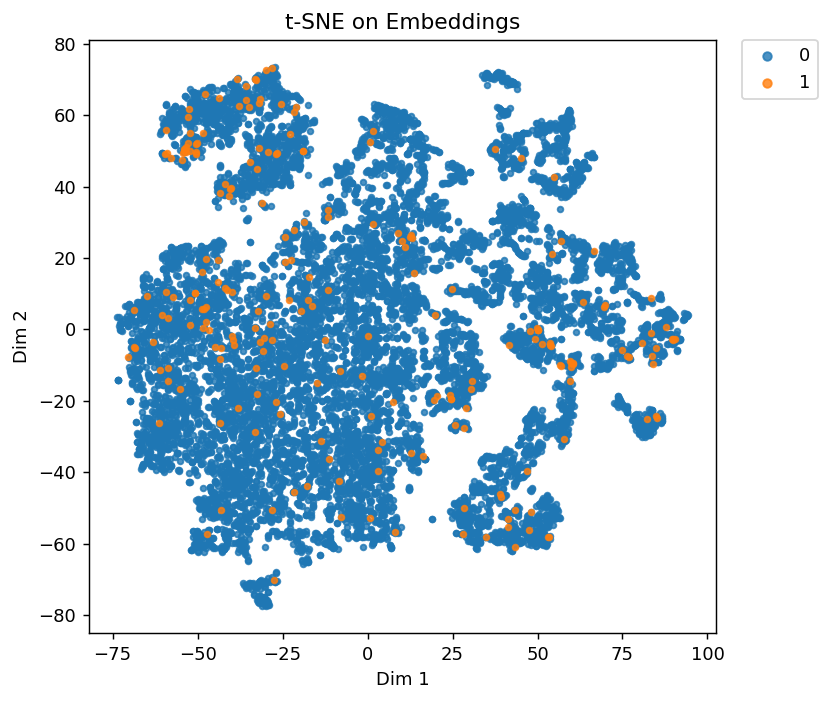

In [18]:
# Pre-reduce to 50D
X50 = linear_reduce(X_emb, n_components=50, random_state=42)

# t-SNE with settings parallel to the FP notebook
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=1000,
    init="pca",
    random_state=42,
    metric="cosine",      # cosine works well for embeddings
    verbose=1
)
Z_tsne_emb = tsne.fit_transform(X50)

# Plot
plot_2d(Z_tsne_emb, y, title="t-SNE on Embeddings")


### UMAP on embeddings

- **Input:** SMILES-BERT embeddings `(n × 768)` (dense).  
- **Metric:** **cosine** (appropriate for dense neural embeddings).  
- **UMAP settings:** `n_neighbors=30`, `min_dist=0.1`, `metric="cosine"`, `random_state=42`.  
- **Rationale:** cosine captures angular similarity; `n_neighbors` trades local vs global structure, and `min_dist` controls cluster tightness.  
  *(Optional: run on `PCA(50)` output to mirror the t-SNE preprocessing.)*


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


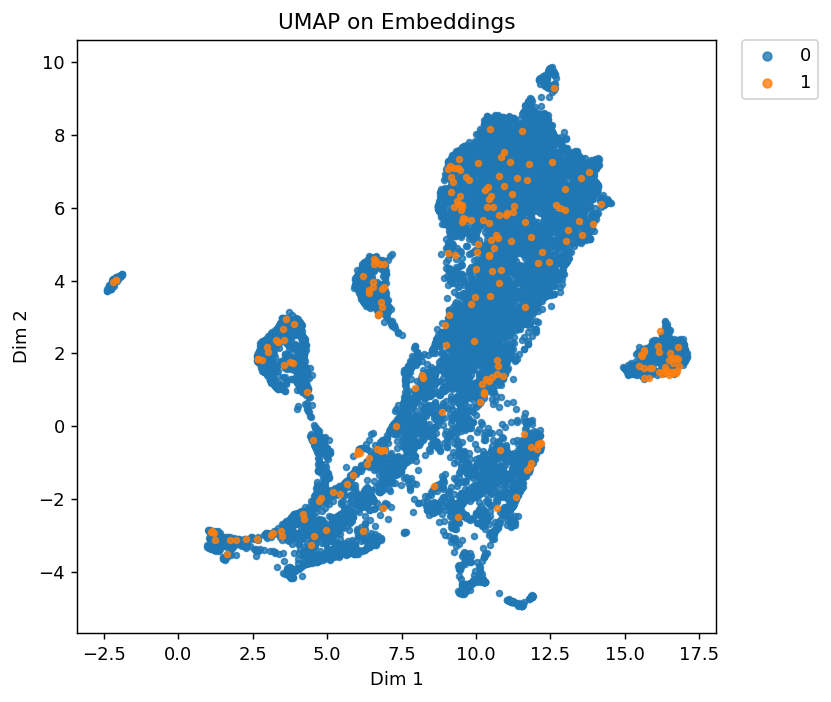

In [19]:
# Use cosine for dense embeddings
metric = "cosine"

umap_model = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,       # 0.0 = tighter; 0.5 = more spread
    n_components=2,
    metric=metric,
    random_state=42
)
Z_umap_emb = umap_model.fit_transform(X_emb)

plot_2d(Z_umap_emb, y, title=f"UMAP on Embeddings")
